## Weather in Szeged 2006-2016
### Regression based analysis for predicting apparent temperatures based on Hourly/daily weather summary with temperature, pressure, wind speed and more parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
%matplotlib inline

### 1. Importing Data

The data consists of weather information for a location called szeged in hungary. It is an historical meteorological data collected over the period of 10 years from 2006 to 2016

In [2]:
df_weather = pd.read_csv('weatherHistory.csv')
df_weather.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
#Let us now see how many observations that we have and how many attributes are available

print(f'The total number of attributes are {df_weather.shape[1]}')
print(f'The total number of observations are {df_weather.shape[0]}')

The total number of attributes are 12
The total number of observations are 96453


The target of this machine learning exercise is to identify the best model to predict the apparent temperature using the input variables available in the data set.

Apparent temperature is the temperature equivalent perceived by humans, caused by the combined effects of air temperature, relative humidity and wind speed. We will be focussing more on the prediction rather the interpretation of the results. This is because we already know the major factors which actually impact the Apparent temperature.

### 2. Data Cleaning and Wrangling

In [4]:
## Let us check the datatypes of the input variables

df_weather.dtypes

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object

In [5]:
### First of all lets us separate the columns based on dtypes.

maskfloat = df_weather.dtypes == float
columns_float = df_weather.columns[maskfloat]

maskobject = df_weather.dtypes == object
columns_object = df_weather.columns[maskobject]

In [6]:
### let us check no of unique values in each column

print(df_weather[columns_float].nunique())
print(df_weather[columns_object].nunique())

Temperature (C)             7574
Apparent Temperature (C)    8984
Humidity                      90
Wind Speed (km/h)           2484
Wind Bearing (degrees)       360
Visibility (km)              949
Loud Cover                     1
Pressure (millibars)        4979
dtype: int64
Formatted Date    96429
Summary              27
Precip Type           2
Daily Summary       214
dtype: int64


* The attribute 'Loud Cover' has only one unique value thus it is not going to add any information to our data
* The attribute 'Formatted Date' has distinct values in all its observation and rightly so since it is date and time information. 

Thus we can drop these two attributes.

In [7]:
## Now lets check for the missing values

df_weather.isnull().sum(axis = 0)

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [8]:
# Alright so we have 517 missing values in the columns 'Precip Type', lets treat them first. 
# For that we need to see what are the existing values in the column

df_weather['Precip Type'].value_counts()

rain    85224
snow    10712
Name: Precip Type, dtype: int64

So the column contains is a categorical variable, which contains only two values and they seem to be non-ordinal. Additonally 
if we delete these variables it will have minimal impact on our total analysis (517 observations out of 96453).
So we can drop these observations

In [9]:
# Further lets look in another variable 'Daily summary' to understand it little better

df_weather['Daily Summary'].value_counts()

Mostly cloudy throughout the day.                                                         20085
Partly cloudy throughout the day.                                                          9981
Partly cloudy until night.                                                                 6169
Partly cloudy starting in the morning.                                                     5184
Foggy in the morning.                                                                      4201
                                                                                          ...  
Light rain overnight.                                                                        24
Overcast starting in the morning.                                                            24
Mostly cloudy until night and breezy starting in the morning continuing until evening.       24
Mostly cloudy starting in the evening.                                                       24
Foggy starting overnight continuing unti

In [10]:
# Let us group by features ['Daily Summary', 'Formatted Date'] and 
# apply functions to check if the enteries remain same during the day for first 10 daily summaries in dataframe

print(df_weather.groupby(['Daily Summary', 'Formatted Date'])['Temperature (C)'].count().to_frame().head(240).sum(level = 0))

                                                    Temperature (C)
Daily Summary                                                      
Breezy and foggy starting in the evening.                        24
Breezy and foggy until morning.                                  24
Breezy and mostly cloudy overnight.                              24
Breezy and partly cloudy in the afternoon.                       24
Breezy in the morning and foggy in the evening.                  24
Breezy in the morning and mostly cloudy startin...               24
Breezy in the morning and mostly cloudy startin...               24
Breezy in the morning and partly cloudy startin...               24
Breezy overnight and mostly cloudy throughout t...               48


In [11]:
# lets check the same conditions for 'Summary' attribute

print(df_weather.groupby(['Summary', 'Formatted Date'])['Temperature (C)'].count().to_frame().head(240).sum(level = 0))

                          Temperature (C)
Summary                                  
Breezy                                 54
Breezy and Dry                          1
Breezy and Foggy                       35
Breezy and Mostly Cloudy              150


This means that the values in daily summary will remain same for all 24 enteries (24 hours) during the day. On the other hand if you see another variable 'Summary', it changes many times during the day. So, it seems it is safe to say the column daily summary can be dropped without losing any major information.

In [12]:
## Let us also check our dataset for zero values as this will create problem, if we are going to do a tranformation exercise.

(df_weather == 0).sum()

Formatted Date                  0
Summary                         0
Precip Type                     0
Temperature (C)               325
Apparent Temperature (C)       69
Humidity                       22
Wind Speed (km/h)            1297
Wind Bearing (degrees)       2264
Visibility (km)               450
Loud Cover                  96453
Pressure (millibars)         1288
Daily Summary                   0
dtype: int64

We can see that there are many zero values, but all are very much plausible except for pressure which cannot be 0, otherwise we would have vacuum in Szeged. So we can fill values from previous observation.

In [13]:
df_weather['Pressure (millibars)'] = df_weather['Pressure (millibars)'].replace(0, np.nan).fillna(method = 'pad')

In [14]:
#So lets put into all actions that we identified in previous steps.

df_weather.dropna(inplace = True)
print(f'Remaining no of observations {df_weather.shape[0]}')

Remaining no of observations 95936


In [15]:
# Now lets drop columns

df_weather.drop(['Daily Summary', 'Formatted Date', 'Loud Cover'], axis = 1, inplace = True)
df_weather.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51


### Data Cleaning and Wrangling - Summary

* Since we are not doing time-series analysis, I have dropped the Formatted date column from our data
* loud cover (I think it is typo for Cloud Cover) attribute is a constant. So we can drop it.
* We tested categorical variables such as Precip type, Daily Summary and Summary attributes for information they contribute to the dataset. Preliminary analysis suggests that we can safely drop Daily Summary data as it remains constant over a day.
* We also checked the null values and 0 values. We dropped observations with null values in precip type and treated 0 values in pressure column, because if we don't do that, it practically means szeged had perfect vaccum atmosphere for those many time periods!!

### 3. Exploratory Data Analysis

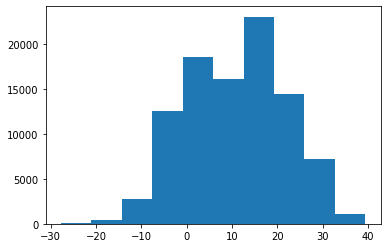

In [16]:
## Lets first of all check whether output variable is normally distributed or not.
plt.hist(df_weather['Apparent Temperature (C)']);

In [17]:
# Looks fairly normal. But let us reconfirm using skew method and set our threshold at 0.75. i.e. 
#if the value is less than -0.75 or greater than 0.75, we will normalize the data

df_weather['Apparent Temperature (C)'].skew()

-0.05903952688910773

So our data is fairly normal, thus we need do not require to peform any kind of normalization operation on the target data.

#### 3.1 Categorical Variables

Next let's check whether our categorical variables add any meaningful information to the model.

We have two such variables 'Summary' and 'Precip Type'

#### Statement 1 - Does precipitation play significant role in predicting temperature?

#### Null Hypothesis: There is no significant difference between the mean temperature on rainy and non-rainy days

#### Alternate Hypothesis: There is a significant difference between the mean temperature on rainy and non-rainy days

In [18]:
from scipy.stats import ttest_ind

test_statistics, p_value = ttest_ind(df_weather.loc[df_weather['Precip Type'] == 'rain', 'Temperature (C)'],
                                     df_weather.loc[df_weather['Precip Type'] == 'snow', 'Temperature (C)'],
                                     equal_var = False)

alpha = 0.025

if p_value <= alpha:
    print(f'The null hypothesis can be rejected for values - test statistics: {test_statistics}, p_value: {p_value}')
    
else:
    print(f'The null hypothesis can be accepted for values - test statistics: {test_statistics}, p_value: {p_value}')

The null hypothesis can be rejected for values - test statistics: 415.970493705491, p_value: 0.0


Thus we can conclude that the precipitation type does have strong impact on output variable. So we will keep them for analysis and further one hot encode them.

#### Statement 2 - Does mean temperature varies significantly for different summaries?

#### Null Hypothesis: There is no significant difference between the mean temperature among different summary group

#### Alternate Hypothesis: There is significant difference between the mean temperature among different summary group

In [19]:
from scipy.stats import f_oneway

In [20]:
weather_summary_list = df_weather['Summary'].unique().tolist()

summary_group = [df_weather.loc[df_weather['Summary'] == summary, 'Temperature (C)'] for summary in weather_summary_list]

F, p_value = f_oneway(*summary_group)

alpha = 0.025

if p_value <= alpha:
    print(f'The null hypothesis can be rejected for values - test statistics: {test_statistics}, p_value: {p_value}')
    
else:
    print(f'The null hypothesis can be accepted for values - test statistics: {test_statistics}, p_value: {p_value}')

The null hypothesis can be rejected for values - test statistics: 415.970493705491, p_value: 0.0


Thus all categories under 'Summary' attribute can be converted into features using One-Hot Encoding

In [21]:
df_summary = pd.get_dummies(df_weather['Summary'], prefix = 'Summary', drop_first=False)
df_summary.head()

,Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,Summary_Breezy and Overcast,Summary_Breezy and Partly Cloudy,Summary_Clear,Summary_Dangerously Windy and Partly Cloudy,Summary_Drizzle,Summary_Dry,...,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


We will also convert the categorical variable 'Precip Type' in 1's and 0's based on the result of our 1st hypothesis. Note in this case we can utilize drop_first attribute of pd.get_dummies as there are only two categories that are mutually exclusive. This is done reduce redundancy.

In [22]:
df_precip = pd.get_dummies(df_weather['Precip Type'], prefix = 'precip', drop_first=True)
df_precip.head()

,precip_snow
0,0
1,0
2,0
3,0
4,0


In [23]:
## Lets once again transform our main dataframe by adding these features and droping the original categorical variables

df_weather_update1 = pd.concat([df_weather, df_summary, df_precip], axis = 1)
df_weather_update1.drop(['Precip Type', 'Summary'], axis = 1, inplace = True)

In [24]:
print(f'The total number of attributes are {df_weather_update1.shape[1]}')
print(f'The total number of observations are {df_weather_update1.shape[0]}')

The total number of attributes are 35
The total number of observations are 95936


By doing exploratory data analysis on the categorical variables we have now increased the number of features from 12 to 35

#### 3.2 Numerical Variables

Now lets handle our numerical variables and check how much information they carry, which describes our output variable. Best way to do this would be to check the correlation between all numerical features (exclusing the one-hot encoded variables) and the target variable

In [25]:
## let us recall our numerical features using the columns_float list which we created earlier.

df_weather_num = df_weather_update1[[columns for columns in columns_float if columns in df_weather.columns]]

In [26]:
X_num = df_weather_num[['Humidity',
                    'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
                    'Pressure (millibars)', 'Temperature (C)']].copy()
y = df_weather_num[['Apparent Temperature (C)']].copy()

In [27]:
## Like earlier done for target variable, let us check the skewness of the features and set the threshold at 0.75.

dict(X_num.skew())

{'Humidity': -0.7150256591968218,
 'Wind Speed (km/h)': 1.115994719744344,
 'Wind Bearing (degrees)': -0.15479254225815275,
 'Visibility (km)': -0.49211431669314815,
 'Pressure (millibars)': 0.09103045515189714,
 'Temperature (C)': 0.09179694354157196}

So we can see here that one of our variables is way above our threshold which is wind speed. So let us try to transform it to make it normal.

In [28]:
print(f"The skew value for log tranformation is {X_num['Wind Speed (km/h)'].apply(np.log1p).skew()}")
print(f"The skew value for square root tranformation is {X_num['Wind Speed (km/h)'].apply(np.sqrt).skew()}")

The skew value for log tranformation is -0.7994007049617369
The skew value for square root tranformation is -0.020179540555325625


We can see that square root transformation provides superior result so let us apply that on our variable

In [29]:
X_num['Wind Speed (km/h)'] = X_num['Wind Speed (km/h)'].apply(np.sqrt)

In [30]:
dict(X_num.skew())

{'Humidity': -0.7150256591968218,
 'Wind Speed (km/h)': -0.020179540555325625,
 'Wind Bearing (degrees)': -0.15479254225815275,
 'Visibility (km)': -0.49211431669314815,
 'Pressure (millibars)': 0.09103045515189714,
 'Temperature (C)': 0.09179694354157196}

So will all our values transformed let us now check the correlation between the features. Features that have correlation more that 0.9 should be dropped.

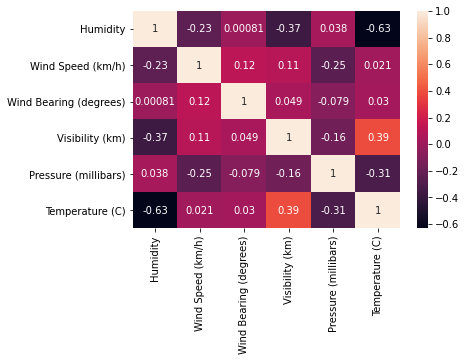

In [31]:
sns.heatmap(X_num.corr(), annot = True);

So, all our features are not strongly correlated with each other. As such we can keep them all. So finally lets add these variables to our final dataframe which we will use for modelling

In [32]:
# dropping untranformed numerical columns
df_weather_update1 = df_weather_update1.drop(list(X_num.columns), axis = 1)
# adding transformed columns
df_weather_update2 = pd.concat([X_num, df_weather_update1], axis = 1)
df_weather_update2.head()

,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Temperature (C),Apparent Temperature (C),Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,...,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,precip_snow
0,0.89,3.757619,251.0,15.8263,1015.13,9.472222,7.388889,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.86,3.776851,259.0,15.8263,1015.63,9.355556,7.227778,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.89,1.982019,204.0,14.9569,1015.94,9.377778,9.377778,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.83,3.755476,269.0,15.8263,1016.41,8.288889,5.944444,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.83,3.323342,259.0,15.8263,1016.51,8.755556,6.977778,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# finally let's see how many observations and features are available 
print(f'The total number of features are {df_weather_update2.shape[1]-1}')
print(f'The total number of observations are {df_weather_update2.shape[0]}')

The total number of features are 34
The total number of observations are 95936


### Summary - EDA

* During EDA we first tried to ascertain that our target variable is normally distributed and found that it is indeed normally distributed. We used .skew() method under pandas.
* Next we went into hypothesis generation and testing process to identify whether our categorical variables explain some variance in the target variable or not.
* Eventually we kept both categorical variables and one hot encoded them to make them ready for further modelling process.
* Bigger challenge was to select our numerical features which we did in two steps first we checked how many of them are skewed and require transformation. We finally ended up transforming only Wind Speed parameter.
* In the end we checked correlations between numerical variables and found them to be within limits.

### 4. Model Selection and Evaluation

In [34]:
#importing all necessary modules, functions and methods

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [35]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [36]:
X_final = df_weather_update2.drop('Apparent Temperature (C)', axis = 1).copy()
y_final = df_weather_update2['Apparent Temperature (C)'].copy()

#### Linear Regression

Now, we will use the GridSearchCV function for identifying the best parameters for Linear Regression Model.

* We will first create a pipeline containing polynomial features, standard scaler and regression function itself
* We will next set the parameters over which the GridSearchCV will iterate to find best value

In [37]:
# linear_estimator = Pipeline([('polynomialfeatures', PolynomialFeatures()),
#                              ('standardscaler', StandardScaler()),
#                              ('linearregression', LinearRegression())
#                             ])

# params = {'polynomialfeatures__degree': [1,2,3]} 

# gridlinear = GridSearchCV(linear_estimator, params, cv = kf)

In [38]:
# gridlinear.fit(X_final, y_final)

In [39]:
## Finally lets save the model in pickled form for future reference

def pickle_model(model, filename):
    pkl.dump(model, open(filename, 'wb'))
    
def de_pickle(model):
    return pkl.load(open(model, 'rb'))

In [40]:
#pickle_model(gridlinear, 'finallinearmodel.sav')

Note: I usually pickle my model after training to avoid intoducing any accidental change in parameters while re-runing my notebook.

In [41]:
finallinearmodel = de_pickle('finallinearmodel.sav')

In [42]:
# Let us get the best parameter value

print(f'The best parameters identified using GridSearchCV method is {finallinearmodel.best_params_}')

The best parameters identified using GridSearchCV method is {'polynomialfeatures__degree': 1}


In [43]:
## Let us finally preedict the values
y_predict = finallinearmodel.predict(X_final)

In [44]:
## Getting R2 Score for model 
linear_r2 = r2_score(y_final, y_predict)
print(f'The R2 Score for linear model is {linear_r2}')

The R2 Score for linear model is 0.9904365492780018


In [45]:
## Now lets get a list of coefficients in order of their weightage in the final model

feature_weights = pd.Series(finallinearmodel.best_estimator_.named_steps['linearregression'].coef_[1:], index = X_final.columns).to_frame()
feature_weights.sort_values(by = 0, ascending = False)

,0
Temperature (C),1.074134e+01
Humidity,1.915475e-01
Pressure (millibars),1.170816e-01
Wind Bearing (degrees),7.409348e-02
Visibility (km),2.396611e-02
precip_snow,-1.451823e-01
Wind Speed (km/h),-6.758610e-01
Summary_Breezy and Dry,-1.870169e+08
Summary_Windy and Dry,-1.870169e+08
Summary_Dangerously Windy and Partly Cloudy,-1.870169e+08


In [46]:
coefficients_linear = list(finallinearmodel.best_estimator_.named_steps['linearregression'].coef_)

Non_zero_coefficients_linear = len(coefficients_linear) - coefficients_linear.count(0)

print(f'Total number of Non-zero features: {Non_zero_coefficients_linear}')

Total number of Non-zero features: 35


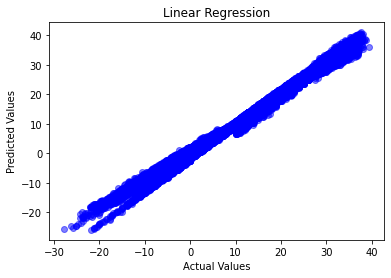

In [47]:
ax = plt.axes()
ax.scatter(x = y_final, y = y_predict, alpha = 0.5, c = 'blue', marker = 'o')
ax.set(xlabel = 'Actual Values',
       ylabel = 'Predicted Values',
       title = 'Linear Regression'
      );

#### Ridge Regression

Now lets repeat the above process but now with Ridge regression and with alpha values between 0.001 to 1

In [48]:
# ridge_estimator = Pipeline([('polynomialfeatures', PolynomialFeatures()),
#                              ('standardscaler', StandardScaler()),
#                              ('ridgeregression', Ridge())
#                             ])

# params = {'polynomialfeatures__degree': [1,2,3],
#           'ridgeregression__alpha': np.geomspace(0.001, 1, 10)
#          } 

# gridridge = GridSearchCV(ridge_estimator, params, cv = kf)

In [49]:
#gridridge.fit(X_final, y_final)

In [50]:
# pickle_model(gridridge, 'finalridgemodel.sav')

In [51]:
finalridgemodel = de_pickle('finalridgemodel.sav')

In [52]:
print(f'The best parameters identified using GridSearchCV method is {finalridgemodel.best_params_}')

The best parameters identified using GridSearchCV method is {'polynomialfeatures__degree': 3, 'ridgeregression__alpha': 1.0}


In [53]:
y_predict2 = finalridgemodel.predict(X_final)  

In [54]:
ridge_r2 = r2_score(y_final, y_predict2)
print(f'The R2 Score for Ridge model is {ridge_r2}')

The R2 Score for Ridge model is 0.9980186748088711


In [55]:
coefficients_ridge = list(finalridgemodel.best_estimator_.named_steps['ridgeregression'].coef_)

Non_zero_coefficients_ridge = len(coefficients_ridge) - coefficients_ridge.count(0)

print(f'Total number of Non-zero features: {Non_zero_coefficients_ridge}')

Total number of Non-zero features: 1199


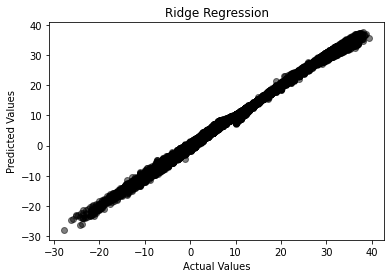

In [56]:
ax = plt.axes()
ax.scatter(x = y_final, y = y_predict2, alpha = 0.5, c = 'black', marker = 'o')
ax.set(xlabel = 'Actual Values',
       ylabel = 'Predicted Values',
       title = 'Ridge Regression'
      );

Here, we can see that No of features have dramatically increased to 1199. But the r2_score has risen to 0.9980 from 0.9904, which shows an improvement. Another thing to notice here is that alpha value selected by GridSearchCV is the highest that we have inputed for alpha. But with so many features we are actually getting a very complex model with very improvement on the r2_score

### Lasso Regression

Now lets repeat the above process but now with Lasso regression and with alpha values between 0.001 to 1

In [57]:
# lasso_estimator = Pipeline([('polynomialfeatures', PolynomialFeatures()),
#                              ('standardscaler', StandardScaler()),
#                              ('lassoregression', Lasso(max_iter = 5000))
#                             ])

# params = {'polynomialfeatures__degree': [1,2,3],
#           'lassoregression__alpha': np.geomspace(0.001, 1, 10)} 

# gridlasso = GridSearchCV(lasso_estimator, params, cv = kf)

In [58]:
#gridlasso.fit(X_final, y_final)

In [59]:
#pickle_model(gridlasso, 'finallassomodel.sav')

In [60]:
finallassomodel = de_pickle('finallassomodel.sav')

In [61]:
print(f'The best parameters identified using GridSearchCV method is {finallassomodel.best_params_}')

The best parameters identified using GridSearchCV method is {'lassoregression__alpha': 0.001, 'polynomialfeatures__degree': 3}


In [62]:
y_predict3 = finallassomodel.predict(X_final)

In [63]:
lasso_r2 = r2_score(y_final, y_predict3)
print(f'The R2 Score for Lasso model is {lasso_r2}')

The R2 Score for Lasso model is 0.9978566384221621


In [64]:
coefficients_lasso = list(finallassomodel.best_estimator_.named_steps['lassoregression'].coef_)

Non_zero_coefficients_lasso = len(coefficients_lasso) - coefficients_lasso.count(0)

print(f'Total number of Non-zero features: {Non_zero_coefficients_lasso}')

Total number of Non-zero features: 213


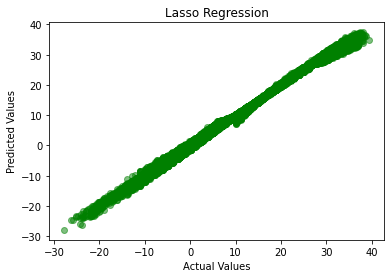

In [65]:
ax = plt.axes()
ax.scatter(x = y_final, y = y_predict3, alpha = 0.5, c = 'green', marker = 'o')
ax.set(xlabel = 'Actual Values',
       ylabel = 'Predicted Values',
       title = 'Lasso Regression'
      );

So, we can see that with lasso regressionn we have been able to improve our r2_score to 0.9978 when compared to linear regression and no of non-zero features have increased to 213 with level 3 polynomial features. Though, the r2_score is slightly less than what we acheived through ridge modelling, but it is a far less complex model (ridge had 1199 features).

In [66]:
#Let us check which are these features which we obtained through lasso

final_lasso_features = list(finallassomodel.best_estimator_.named_steps['polynomialfeatures'].get_feature_names(X_final.columns))
Feature_dataframe = pd.DataFrame(coefficients_lasso, index = final_lasso_features, columns = ['Coefficient'])
Feature_dataframe = Feature_dataframe.loc[Feature_dataframe.Coefficient !=0]
Feature_dataframe = Feature_dataframe.sort_values(by = 'Coefficient', ascending = False, key = lambda x: np.abs(x))

In [67]:
Feature_dataframe.head(10)

,Coefficient
Temperature (C),8.474063
Wind Speed (km/h) Temperature (C),3.365365
Wind Speed (km/h) Temperature (C)^2,-2.843058
Wind Speed (km/h)^2 Pressure (millibars),-2.574144
Wind Speed (km/h)^3,1.365309
Temperature (C)^3,0.934295
Wind Speed (km/h)^2 Temperature (C),0.688926
Humidity Wind Speed (km/h) Temperature (C),0.613873
Humidity^2 Temperature (C),-0.553206
Humidity Wind Speed (km/h),-0.431659


In [68]:
## How about checking which original features from our dataframe were finally selected by the model
final_features = {}
for idx in Feature_dataframe.index:
    if idx in X_final.columns:
        final_features[idx] = Feature_dataframe.loc[idx][0]

print(final_features)

{'Temperature (C)': 8.474063013468031, 'Wind Bearing (degrees)': 0.05778722499614497, 'Summary_Foggy': -0.054222242781559446, 'precip_snow': -0.051797456673782244, 'Pressure (millibars)': 0.01696110202986395, 'Wind Speed (km/h)': -0.016720720366940698, 'Humidity': 0.0035179518971180496}


### Summary - Model Selection and Evaluation

* We evaluated three model types with same intial features 
    1. Polynomial degree = 3
    2. Cross Validation Splits = 3
* After completing the modelling we were able to acheive quiet significant results from all three models. The Optimised Model Parameters were selected through GridSearchCV method over values of alpha varying from 0.001 to 1
* The model results are listed below

In [69]:
Result_df = pd.DataFrame(index = ['Linear Regression', 'Ridge Regression', 'Lasso Regressiom'],
                         data = [[1, np.nan, Non_zero_coefficients_linear, linear_r2],
                                 [3, 1, Non_zero_coefficients_ridge, ridge_r2],
                                 [3, 0.001, Non_zero_coefficients_lasso, lasso_r2]
                                ],
                         columns = ['Polynomial Degree', 'Alpha', 'No of Features', 'R2 Score']
                        )
Result_df

,Polynomial Degree,Alpha,No of Features,R2 Score
Linear Regression,1,NaN,35,0.990437
Ridge Regression,3,1.000,1199,0.998019
Lasso Regressiom,3,0.001,213,0.997857


* Lasso Regression model provides a comfortable balance between the complexity and performance by providing improvement over simple linear model at the same time toning down the complexity below ridge model 
* In terms of interpretation we can very easily conclude that the factors which seem to impact apparent temperature include 'Temperature (C)', 'Wind Bearing (degrees)', 'Summary_Foggy', 'precip_snow', 'Pressure (millibars)', 'Wind Speed (km/h)', 'Humidity' and there various interaction terms to the degree 3. 
* The order of importance of each 1st degree feature in absolute terms is shown below

In [70]:
Feature_weightage = pd.DataFrame(index = final_features.keys(), data = final_features.values(), columns = ['Value'])
Feature_weightage = Feature_weightage.sort_values(by = 'Value', ascending = False, key = lambda x: np.abs(x))
Feature_weightage

,Value
Temperature (C),8.474063
Wind Bearing (degrees),0.057787
Summary_Foggy,-0.054222
precip_snow,-0.051797
Pressure (millibars),0.016961
Wind Speed (km/h),-0.016721
Humidity,0.003518


* However, we should be careful while interpreting these results - since apparent temperature is calculated using a well established scientific formula. Not to forget we finalized a lasso model which deletes certain features which raises uncertainity on our interpretation. 
* Nevertheless, our model has indeed demonstrated a very good prediction power, which was our primary objective, and can be used to estimate future values quite reliably.

### 5. Conclusion and Future Directions

In conclusion, we chose Lasso Regression Model for purpose of deployment for future predictions. The model not only shows great prediction power, it is also relatively simple.

In future, 

* We can attempt to re-train our model for even higher values of iteration (I had to limit my iteration to 5000, due to memory error) and alpha parameters of ridge and lasso regression. 
* We may also try to eliminate categorical variables entirely and check the their impact on the model. 
* Attempting modelling using any higher degree of polynomial may improve the accuracy but at the cost of complexity (thereby overfitting the data).
* Another things that is required to be kept in mind is that the model depends on certain categorical values (features), thereby it is important to ensure that those categorisations are done based on well defined parameters. Any time those parameters change we will be required to accordingly re-train our model based on those updated categories.

## Thank You, for visiting my page and going through this notebook.

# CIAO !!